# 1. Importing Dependencies

In [31]:
import matplotlib.pyplot as plt
import numpy as np
import networkx as nx
from scipy.integrate import solve_ivp
import scienceplots
plt.style.use(['science', 'notebook', 'grid'])

# 2. Reservoir Computing Algorithim

In [32]:
def set_random_seed(seed):
        np.random.seed(seed)

def linear_regression(R, trajectory, beta=0.0001):
    Rt = np.transpose(R)
    inverse_part = np.linalg.inv(np.dot(R, Rt) + beta * np.identity(R.shape[0]))                # Tikhonov Regularization
    return np.dot(np.dot(trajectory.T, Rt), inverse_part)   

def sigmoid(x):                                                                 #In paper tanh was used, here we are using sigmoid, both give similar result
    return np.where(x >= 0,
                    1 / (1 + np.exp(-x)),
                    np.exp(x) / (1 + np.exp(x)))

In [33]:
def generate_adjacency_matrix(dim_reservoir, rho, sigma):

    np.random.seed(30)
    graph = nx.gnp_random_graph(dim_reservoir, sigma)                           # Generates an Erdos-Renyi graph of nodes = dim_reservoir and probab of node connection = sigma
    graph = nx.to_numpy_array(graph)

    # Ensure random_array is of the same shape as the graph adjacency matrix.
    random_array = 2 * (np.random.rand(dim_reservoir, dim_reservoir) - 0.5)

    # Multiply graph adjacency matrix with random values.
    rescaled = graph * random_array
    return scale_matrix(rescaled, rho)

def scale_matrix(A, rho):
    eigenvalues, _ = np.linalg.eig(A)
    max_eigenvalue = np.amax(eigenvalues)
    A = A/np.absolute(max_eigenvalue) * rho                 # this line makes the spectral radius of matrix A as rho
    return A

In [34]:
class ReservoirComputer:
    def __init__(self, input_dim, reservoir_dim, rho, sigma, seed):

        set_random_seed(seed)
        self.input_dim = input_dim
        self.reservoir_dim = reservoir_dim
        self.A = generate_adjacency_matrix(reservoir_dim, rho, sigma)
        self.W_in = 2 * sigma * (np.random.rand(reservoir_dim, input_dim) - 0.5)
        self.W_out = np.zeros((input_dim, reservoir_dim))
        

    def train(self, training_data,training_data_new):
        R = np.zeros((self.reservoir_dim,training_data.shape[0]))
        R[:,0] = np.ones(self.reservoir_dim)
        for i in range(1,training_data.shape[0]):
            u = training_data[i-1]
            R[:,i] = sigmoid(np.dot(self.A, R[:,i-1]) + np.dot(self.W_in, u.T))
        
        columns_to_remove = np.arange(0,1000)
        self.R = np.delete(R, columns_to_remove, axis = 1)                    # Removes the transient data
        self.W_out = linear_regression(self.R, training_data_new)             # Finds ideal weight matrix mapping data[t] to data[t+1]


    def predict(self, steps):
      prediction = np.zeros((steps, self.input_dim))
      r_state = self.R[:,-1]
      prediction[0] = np.transpose(np.dot(self.W_out, r_state))
      for i in range (1, steps):
          r_state = sigmoid(np.dot(self.A, r_state) + np.dot(self.W_in, prediction[i-1].T))
          prediction[i] = np.transpose(np.dot(self.W_out, r_state))

      return prediction

# 3. Obtaining Data for Chaotic system

Choose the system you want to see predicted and run the apprpriate block

### Lorentz system's Data

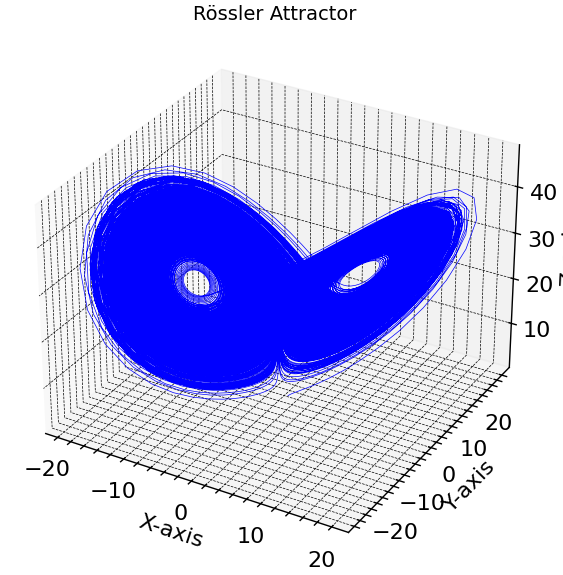

In [45]:
def lorenz_equations(t, X, sigma, rho, beta):
    x, y, z = X
    dxdt = sigma * (y - x)
    dydt = x * (rho - z) - y
    dzdt = x * y - beta * z
    return [dxdt, dydt, dzdt]


sigma = 10
rho = 28
beta = 8/3

XYZ_initial = [1, 1, 1]
t_span = (0, 1000)


sol = solve_ivp(lorenz_equations, t_span, XYZ_initial, args=(sigma, rho, beta), dense_output=True)
t = np.linspace(t_span[0], t_span[1], 50000)
X = sol.sol(t)
x_list, y_list, z_list = X[0], X[1], X[2]

# Plot the Rössler system
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')
ax.plot(x_list, y_list, z_list, lw=0.5, color="blue")
ax.set_title("Rössler Attractor", fontsize=14)
ax.set_xlabel("X-axis")
ax.set_ylabel("Y-axis")
ax.set_zlabel("Z-axis")
plt.show()

### Rossler system's Data

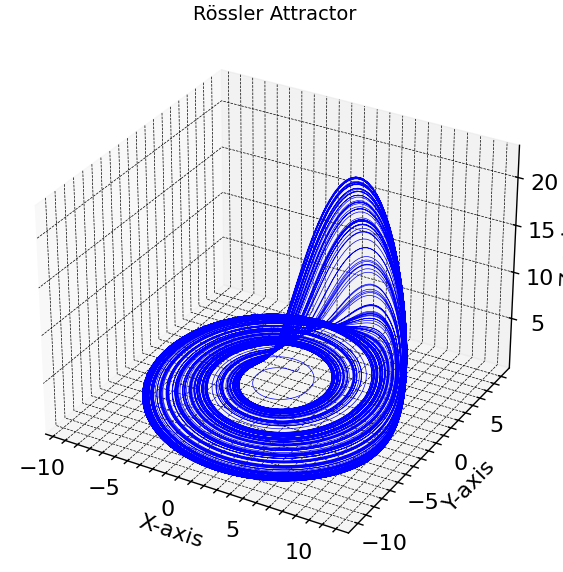

In [ ]:
def rossler_equations(t, X, a, b, c):
    x, y, z = X
    dxdt = -y - z
    dydt = x + a * y
    dzdt = b + z * (x - c)
    return [dxdt, dydt, dzdt]

a = 0.2
b = 0.2
c = 5.7
XYZ_initial = [1, 1, 1]
t_span = (0, 1000)

sol = solve_ivp(rossler_equations, t_span, XYZ_initial, args=(a, b, c), dense_output=True)

t = np.linspace(t_span[0], t_span[1], 50000)
X = sol.sol(t)
x_list, y_list, z_list = X[0], X[1], X[2]

# Plot the Rössler system
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')
ax.plot(x_list, y_list, z_list, lw=0.5, color="blue")
ax.set_title("Rössler Attractor", fontsize=14)
ax.set_xlabel("X-axis")
ax.set_ylabel("Y-axis")
ax.set_zlabel("Z-axis")
plt.show()

# 4. Breaking data to training and testing set

In [37]:
data = []                                                        
for i in range(len(x_list)):
    u_i = [x_list[i], y_list[i], z_list[i]]
    data.append(u_i)

data_without_transient = data[10000:]
data_length = len(data_without_transient)                         # removed transient 
training_percentage = 0.7
training_data = np.array(data_without_transient[:30000])
train_without_transient = training_data[1000:]                   # removes first 1000 rows as warmup(correspondingly removed from the R matrix)
valid_data = np.array(data_without_transient[30000:])

# 5. Using Bayesian Optimization to find hyperparameters

In [ ]:
from skopt import gp_minimize
from skopt.space import Real

def f_x(hyperparameters):
    rho, sigma= hyperparameters
    model = ReservoirComputer(3, 1000, rho, sigma,seed=30) 
    model.train(training_data, train_without_transient)
    predicted_data = model.predict(len(valid_data))
    total_var = np.var(predicted_data)
    NRMSE = np.sqrt(np.mean((valid_data[:] - predicted_data[:]) ** 2) / total_var)
    return NRMSE
    
space = [
    Real(0.1,1, name='rho'),         # You should change the ranges to obtain the correct global minima for error
    Real(0.01,1, name='sigma'),
]

result = gp_minimize(f_x, space, n_calls=80, random_state=int(30))

# Best hyperparameters found
print(f"Best hyperparameters: {result.x}")
print(f"Best score (NRMSE): {result.fun}")  

Best hyperparameters: [0.27488893534515757, 0.14693121046482022]
Best score (NRMSE): 0.33961267224212915


# 6. Initializing the RC

Run the appropriate block for the system you want to predict

RC for lorentz system

In [11]:
reservoir_dim = 1000                                    
model = ReservoirComputer(3, reservoir_dim, 0.8, 0.035,seed=30)      
model.train(training_data, train_without_transient)
predicted_data = model.predict(len(valid_data))

RC for Rossler system

In [40]:
reservoir_dim = 1000                                    
model = ReservoirComputer(3, reservoir_dim, 0.274, 0.146,seed=30)      
model.train(training_data, train_without_transient)
predicted_data = model.predict(len(valid_data))

# 7. Predictions

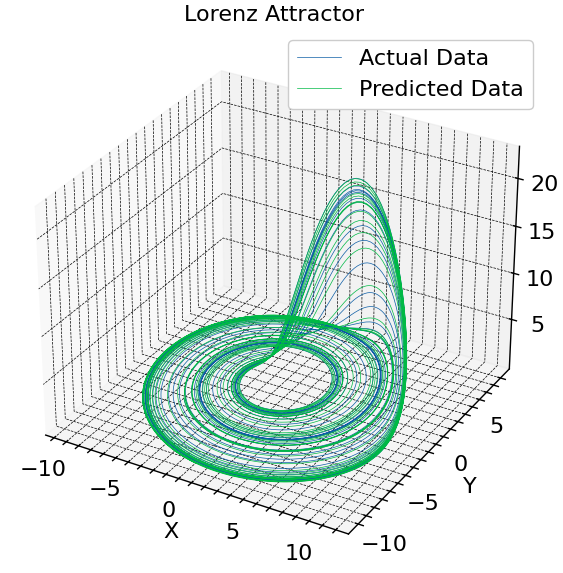

In [41]:
fig = plt.figure(figsize=(10, 7))

x_data = valid_data[:, 0]
y_data = valid_data[:, 1]
z_data = valid_data[:, 2]

x_pred = predicted_data[:, 0]
y_pred = predicted_data[:, 1]
z_pred = predicted_data[:, 2]

ax = fig.add_subplot(111, projection='3d')

ax.plot(x_data, y_data, z_data, lw=0.5, label="Actual Data")
ax.plot(x_pred, y_pred, z_pred, lw=0.5, label="Predicted Data")
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_title('Lorenz Attractor')
ax.legend()
plt.show()

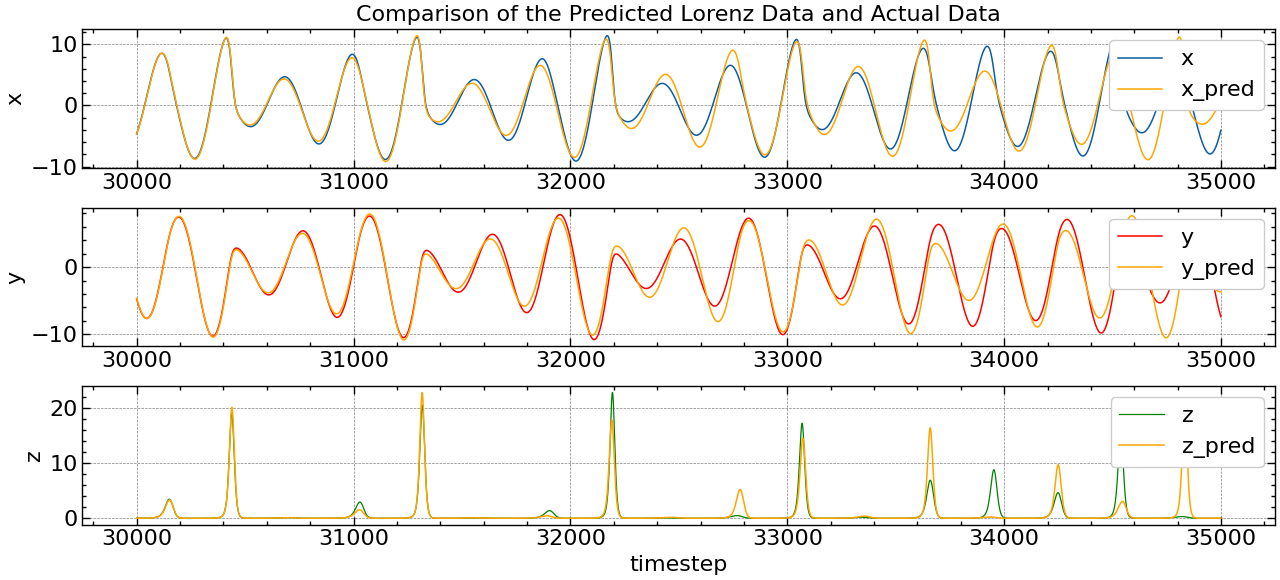

In [42]:

fig, axs = plt.subplots(3, 1, figsize=(13, 6))

timesteps = [*range(training_data.shape[0], data_length, 1)]

# Plot data on each subplot
axs[0].plot(timesteps[:5000], x_data[:5000], label="x", lw=1.1)
axs[0].plot(timesteps[:5000], x_pred[:5000], label="x_pred", color='orange', lw=1.1)  
axs[0].set_ylabel("x")
axs[0].set_title("Comparison of the Predicted Lorenz Data and Actual Data")
axs[0].legend(loc='upper right')

axs[1].plot(timesteps[:5000], y_data[:5000], label="y", color='r', lw=1.1)
axs[1].plot(timesteps[:5000], y_pred[:5000], label="y_pred", color='orange', lw=1.1)  
axs[1].set_ylabel("y")
axs[1].legend(loc='upper right')

axs[2].plot(timesteps[:5000], z_data[:5000], label="z", color='g', lw=.9)
axs[2].plot(timesteps[:5000], z_pred[:5000], label="z_pred", color='orange', lw=1.1)  
axs[2].set_ylabel("z")
axs[2].set_xlabel("timestep")
axs[2].legend(loc='upper right')

fig.tight_layout()

plt.show()


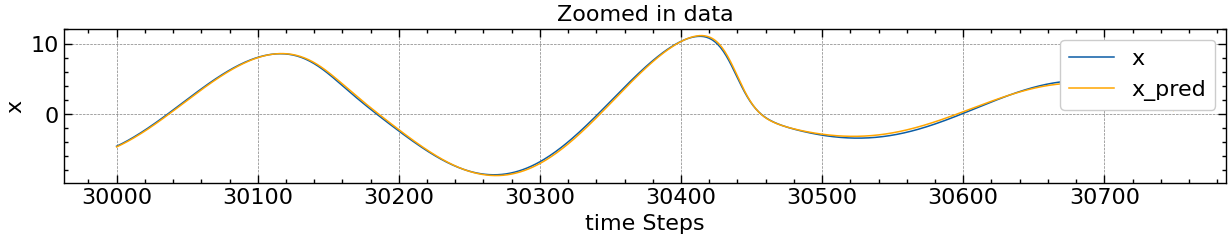

In [43]:
plt.figure(figsize=(15,2))
plt.plot(timesteps[0:750], x_data[:750], label="x", lw=1.1)
plt.plot(timesteps[0:750], x_pred[:750], label="x_pred", color='orange', lw=1.1)  
plt.ylabel("x")
plt.xlabel("time Steps")
plt.title("Zoomed in data")
plt.legend(loc='upper right')
plt.show()

In [51]:
import numpy as np

def nrmse(y_true, y_pred, normalization='range'):
    mse = np.mean((y_true - y_pred) ** 2)
    rmse = np.sqrt(mse)
    
    if normalization == 'range':
        norm_factor = np.max(y_true) - np.min(y_true)
    elif normalization == 'mean':
        norm_factor = np.mean(y_true)
    else:
        raise ValueError("Normalization method should be either 'range' or 'mean'")
    
    nrmse_value = rmse / norm_factor
    return nrmse_value

true_data = valid_data
predicted_data = predicted_data

print("NRMSE (normalized by range):", nrmse(true_data, predicted_data, normalization='range'))
print("NRMSE (normalized by mean):", nrmse(true_data, predicted_data, normalization='mean'))


NRMSE (normalized by range): 0.04120882785925923
NRMSE (normalized by mean): 35.27885301272457
